# Given the regular season performance statistics, can you predict whether a player will receive the 2021 MVP nomination?

## Introduction
At the end of each season, a randomly selected group of sports writers in the Baseball Writers Association of America (BBWAA) receive a blank ballot for the Most Valuable Player (MVP) nomination for each league (American and National). The randomly selected writers then get to choose who should be nominated for the year's MVP, ranked based on their opinion. Here's an  excerpt from BBWAA on the rules of MVP nomination:
```
Dear Voter:

There is no clear-cut definition of what Most Valuable means. It is up to the individual voter to decide who was the Most Valuable Player in each league to his team. The MVP need not come from a division winner or other playoff qualifier.

The rules of the voting remain the same as they were written on the first ballot in 1931:

1.  Actual value of a player to his team, that is, strength of offense and defense.

2.  Number of games played.

3.  General character, disposition, loyalty and effort.

4.  Former winners are eligible.

5.  Members of the committee may vote for more than one member of a team.

You are also urged to give serious consideration to all your selections, from 1 to 10. A 10th-place vote can influence the outcome of an election. You must fill in all 10 places on your ballot. Only regular-season performances are to be taken into consideration.

Keep in mind that all players are eligible for MVP, including pitchers and designated hitters.
```

The ballots are then consolidated and aggregated (weighted by the rank), and the Major Leagure Baseball (MLB) posts the top 20 players from each league. **Using one of the supervised learning model techniques I've learned so far, I will build a model that will predict the top 10 MVP nominees for 2021 season.**

## Assumptions and Considerations
In order to keep the model simple, I am making a few assumptions and considerations:
1. Eligible players must have at least 502 plate appearance, in order to weed out any outliers. The number comes from the batting record qualifier [see the Wikipedia page](https://en.wikipedia.org/wiki/Plate_appearance).
1. The training data will be the statistics between 2013 and 2019, and the test data will be the statistics for 2021. I am omitting 2020 data, due to a shorter season induced by Covid-19.
1. Out of 20 nominated players, I am only considering top 10. Because the nominations are subjective, selecting 10 players would be most optimal. Hence, considering both leagues, 20 out of all players with at least 502 plate appearances will be considered nominated as the MVP.
1. Because I intend to look at only hitting records, pitchers will not be considered in my dataset. Only batters, including catchers, will be considered.
1. The data will come from [Baseball Reference](baseball-reference.com) website for the MVP nomination and [FanGraphs](fangraphs.com) for the player statistics. 

## Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import seaborn as sns
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, mean_absolute_error
from sklearn import ensemble
import itertools
from sklearn.model_selection import cross_val_score
from statsmodels.tools.eval_measures import mse, rmse

import warnings
warnings.filterwarnings('ignore')

In [2]:
training_df = pd.read_csv("MVP_TRAINING.csv")
test_df = pd.read_csv("MVP_TEST.csv")

In [3]:
training_df.info()
training_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 27 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Season    991 non-null    int64  
 1   Name      991 non-null    object 
 2   Team      991 non-null    object 
 3   Age       991 non-null    int64  
 4   PA        991 non-null    int64  
 5   G         991 non-null    int64  
 6   H         991 non-null    int64  
 7   1B        991 non-null    int64  
 8   2B        991 non-null    int64  
 9   3B        991 non-null    int64  
 10  HR        991 non-null    int64  
 11  R         991 non-null    int64  
 12  RBI       991 non-null    int64  
 13  BB        991 non-null    int64  
 14  IBB       991 non-null    int64  
 15  SO        991 non-null    int64  
 16  AVG       991 non-null    float64
 17  WAR       991 non-null    float64
 18  wRC+      991 non-null    int64  
 19  WPA       991 non-null    float64
 20  Hard%     991 non-null    object

,Season,Name,Team,Age,PA,G,H,1B,2B,3B,...,WAR,wRC+,WPA,Hard%,OBP+,SLG+,HardHit%,Dol,playerid,MVP
0,2013,Nate Schierholtz,CHC,29,503,137,116,60,32,3,...,1.5,109,0.77,30.60%,93,117,NaN,$11.40,6201.0,0
1,2014,Kurt Suzuki,MIN,30,503,131,130,93,34,0,...,-0.1,106,1.64,25.80%,109,98,NaN,NaN,NaN,0
2,2015,Chris Coghlan,CHC,30,503,148,110,63,25,6,...,3.1,113,0.24,33.00%,105,108,33.30%,$25.10,6878.0,0
3,2015,Ryan Howard,PHI,35,503,129,107,54,29,1,...,-0.2,93,-0.31,37.30%,85,108,45.00%,($1.50),2154.0,0
4,2016,Mitch Moreland,TEX,30,503,147,107,64,21,0,...,0.0,83,-0.16,36.50%,93,99,39.50%,$0.10,3086.0,0


In [4]:
test_df.info()
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 27 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Season    132 non-null    int64  
 1   Name      132 non-null    object 
 2   Team      132 non-null    object 
 3   Age       132 non-null    int64  
 4   PA        132 non-null    int64  
 5   G         132 non-null    int64  
 6   H         132 non-null    int64  
 7   1B        132 non-null    int64  
 8   2B        132 non-null    int64  
 9   3B        132 non-null    int64  
 10  HR        132 non-null    int64  
 11  R         132 non-null    int64  
 12  RBI       132 non-null    int64  
 13  BB        132 non-null    int64  
 14  IBB       132 non-null    int64  
 15  SO        132 non-null    int64  
 16  AVG       132 non-null    float64
 17  WAR       132 non-null    float64
 18  wRC+      132 non-null    int64  
 19  WPA       132 non-null    float64
 20  Hard%     132 non-null    object

,Season,Name,Team,Age,PA,G,H,1B,2B,3B,...,WAR,wRC+,WPA,Hard%,OBP+,SLG+,HardHit%,Dol,playerid,MVP
0,2021,Bryce Harper,PHI,28,599,141,151,73,42,1,...,6.6,170,4.56,43.30%,131,146,49.20%,$53.00,11579,1
1,2021,Juan Soto,WSN,22,654,151,157,106,20,2,...,6.6,163,4.01,39.10%,142,127,52.40%,$53.00,20123,1
2,2021,Vladimir Guerrero Jr.,TOR,22,698,161,188,110,29,1,...,6.7,166,3.22,41.70%,127,145,55.20%,$53.50,19611,1
3,2021,Fernando Tatis Jr.,SDP,22,546,130,135,62,31,0,...,6.1,156,4.10,48.00%,112,145,55.60%,$49.10,19709,1
4,2021,Shohei Ohtani,LAA,26,639,158,138,58,26,8,...,5.1,152,5.18,45.10%,118,142,53.40%,$41.00,19755,1


I see that some columns that should be numeric: `Hard%`, `HardHit%`, and `Dol`. We need to dive more into those three features.

In [5]:
training_df['Hard%'] = training_df['Hard%'].str.rstrip('%').astype('float') / 100.0
training_df['HardHit%'] = training_df['HardHit%'].str.rstrip('%').astype('float') / 100.0
training_df['Dol'] = training_df['Dol'].replace('[\$)]', '', regex=True)
training_df['Dol'] = training_df['Dol'].replace('[(]', '-', regex=True).astype(float)

test_df['Hard%'] = test_df['Hard%'].str.rstrip('%').astype('float') / 100.0
test_df['HardHit%'] = test_df['HardHit%'].str.rstrip('%').astype('float') / 100.0
test_df['Dol'] = test_df['Dol'].replace('[\$)]', '', regex=True)
test_df['Dol'] = test_df['Dol'].replace('[(]', '-', regex=True).astype(float)

Next, we will deal with missing values.

In [6]:
training_df.isnull().any()

Season      False
Name        False
Team        False
Age         False
PA          False
G           False
H           False
1B          False
2B          False
3B          False
HR          False
R           False
RBI         False
BB          False
IBB         False
SO          False
AVG         False
WAR         False
wRC+        False
WPA         False
Hard%       False
OBP+        False
SLG+        False
HardHit%     True
Dol          True
playerid     True
MVP         False
dtype: bool

In [7]:
test_df.isnull().any()

Season      False
Name        False
Team        False
Age         False
PA          False
G           False
H           False
1B          False
2B          False
3B          False
HR          False
R           False
RBI         False
BB          False
IBB         False
SO          False
AVG         False
WAR         False
wRC+        False
WPA         False
Hard%       False
OBP+        False
SLG+        False
HardHit%    False
Dol         False
playerid    False
MVP         False
dtype: bool

Only training dataset has null values, in `HardHit%`, `Dol`, and `playerid`. Because player's id number doesn't matter, we will get rid of `playerid` in both datasets.

In [8]:
training_df = training_df.drop(['playerid'], 1)
test_df = test_df.drop(['playerid'], 1)

In [9]:
print("The 'Hard Hit %'' feature has {} null observations.".format(training_df['HardHit%'].isnull().sum()))
print("The 'dollar value' feature has {} null observations.".format(training_df['Dol'].isnull().sum()))

The 'Hard Hit %'' feature has 286 null observations.
The 'dollar value' feature has 146 null observations.


Out of 991 observations, 286 and 146 is a pretty hefty chunk. We will use interpolation to fill in the null values.

In [10]:
training_df['HardHit%'] = training_df['HardHit%'].interpolate()
training_df['Dol'] = training_df['Dol'].interpolate()

training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991 entries, 0 to 990
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Season    991 non-null    int64  
 1   Name      991 non-null    object 
 2   Team      991 non-null    object 
 3   Age       991 non-null    int64  
 4   PA        991 non-null    int64  
 5   G         991 non-null    int64  
 6   H         991 non-null    int64  
 7   1B        991 non-null    int64  
 8   2B        991 non-null    int64  
 9   3B        991 non-null    int64  
 10  HR        991 non-null    int64  
 11  R         991 non-null    int64  
 12  RBI       991 non-null    int64  
 13  BB        991 non-null    int64  
 14  IBB       991 non-null    int64  
 15  SO        991 non-null    int64  
 16  AVG       991 non-null    float64
 17  WAR       991 non-null    float64
 18  wRC+      991 non-null    int64  
 19  WPA       991 non-null    float64
 20  Hard%     991 non-null    float6

After interpolation, there are still 2 values missing from the `HardHit%` feature. We will just drop the two rows without values.

In [11]:
training_df = training_df.dropna()
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 989 entries, 2 to 990
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Season    989 non-null    int64  
 1   Name      989 non-null    object 
 2   Team      989 non-null    object 
 3   Age       989 non-null    int64  
 4   PA        989 non-null    int64  
 5   G         989 non-null    int64  
 6   H         989 non-null    int64  
 7   1B        989 non-null    int64  
 8   2B        989 non-null    int64  
 9   3B        989 non-null    int64  
 10  HR        989 non-null    int64  
 11  R         989 non-null    int64  
 12  RBI       989 non-null    int64  
 13  BB        989 non-null    int64  
 14  IBB       989 non-null    int64  
 15  SO        989 non-null    int64  
 16  AVG       989 non-null    float64
 17  WAR       989 non-null    float64
 18  wRC+      989 non-null    int64  
 19  WPA       989 non-null    float64
 20  Hard%     989 non-null    float6

Wonderful! Now we will look at outliers.

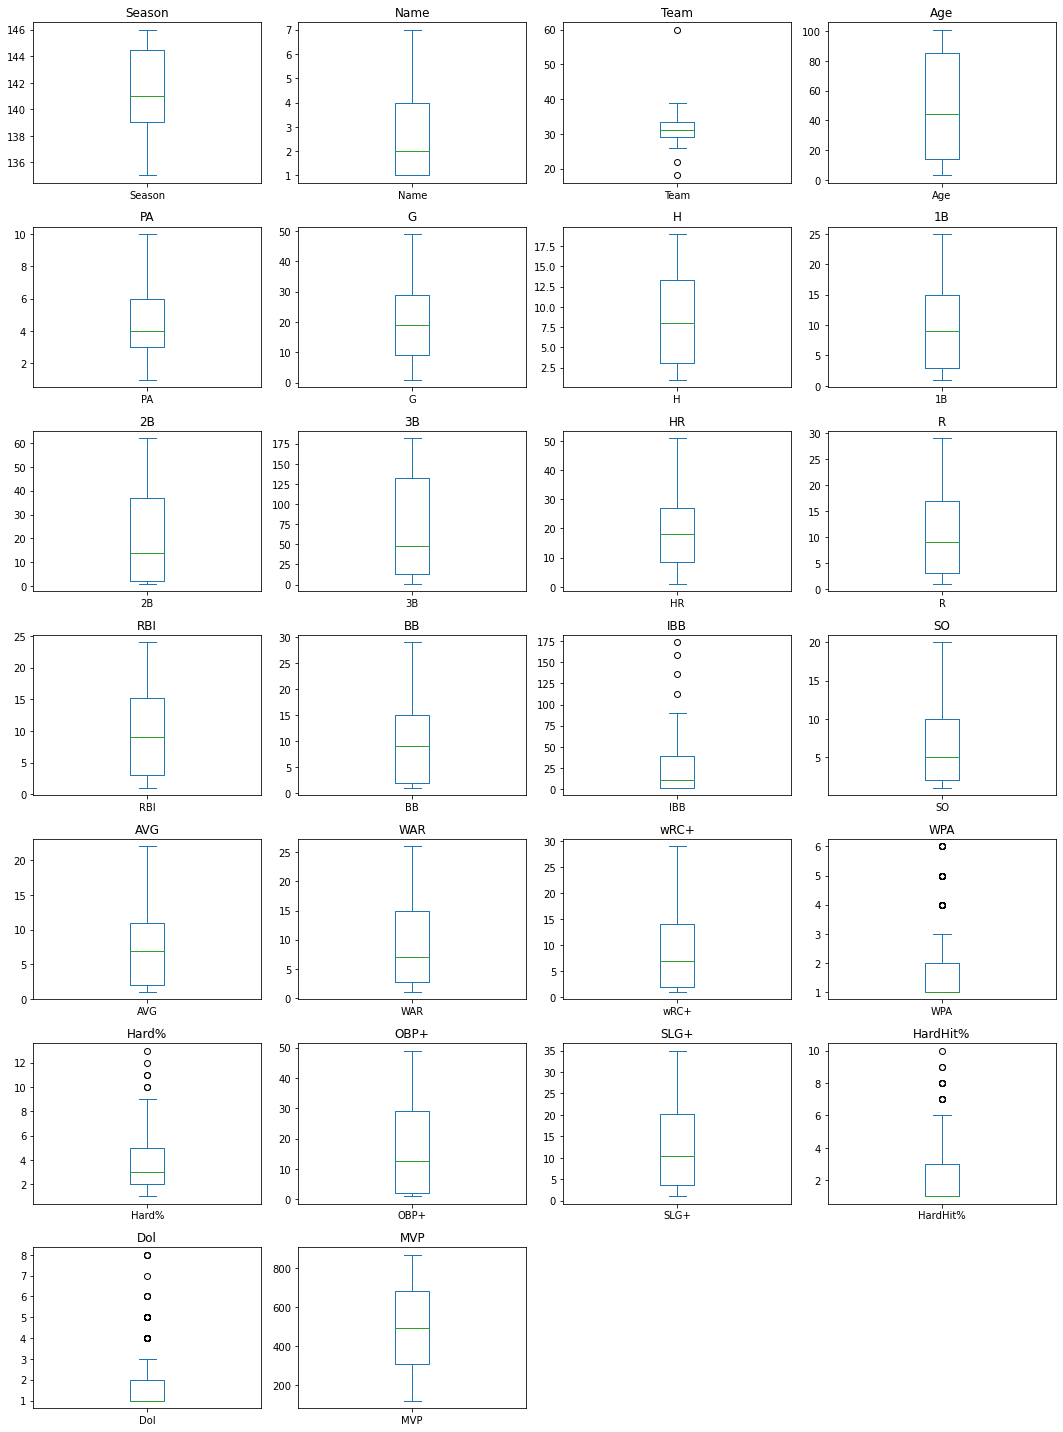

In [12]:
fig = plt.figure(figsize = (15, 20))

for i, col in enumerate(training_df, 1):
    fig.add_subplot(7, 4, i,)
    training_df[col].value_counts().plot(kind='box', ax=plt.gca())
    plt.title(col)
plt.tight_layout()
plt.show()

With the default whisker of 1.5, `Team`, `IBB`, `WPA`, `Hard%`, `HardHit%`, and `Dol` have outliers. The team does not matter for our model, so we will look at the other five features with Tukey's method.

In [13]:
ibb_q75, ibb_q25 = np.percentile(training_df['IBB'], [75, 25])
ibb_iqr = ibb_q75 - ibb_q25

wpa_q75, wpa_q25 = np.percentile(training_df['WPA'], [75, 25])
wpa_iqr = wpa_q75 - wpa_q25

hard_q75, hard_q25 = np.percentile(training_df['Hard%'], [75, 25])
hard_iqr = hard_q75 - hard_q25

hardhit_q75, hardhit_q25 = np.percentile(training_df['HardHit%'], [75, 25])
hardhit_iqr = hardhit_q75 - hardhit_q25

dol_q75, dol_q25 = np.percentile(training_df['Dol'], [75, 25])
dol_iqr = dol_q75 - dol_q25

for threshold in np.arange(1, 5, 0.5):
    ibb_min_val = ibb_q25 - (ibb_iqr * threshold)
    ibb_max_val = ibb_q75 + (ibb_iqr * threshold)
    wpa_min_val = wpa_q25 - (wpa_iqr * threshold)
    wpa_max_val = wpa_q75 + (wpa_iqr * threshold)
    hard_min_val = hard_q25 - (hard_iqr * threshold)
    hard_max_val = hard_q75 + (hard_iqr * threshold)
    hardhit_min_val = hardhit_q25 - (hardhit_iqr * threshold)
    hardhit_max_val = hardhit_q75 + (hardhit_iqr * threshold)
    dol_min_val = dol_q25 - (dol_iqr * threshold)
    dol_max_val = dol_q75 + (dol_iqr * threshold)
    print("\nThe score threshold: {}".format(threshold))
    print("Total intentional walk outlier: {}".format(len((np.where((training_df['IBB']>ibb_max_val) | (training_df['IBB']<ibb_min_val))[0]))))
    print("Total win probability added outlier: {}".format(len((np.where((training_df['WPA']>wpa_max_val) | (training_df['WPA']<wpa_min_val))[0]))))
    print("Total hard percentage outlier: {}".format(len((np.where((training_df['Hard%']>hard_max_val) | (training_df['Hard%']<hard_min_val))[0]))))
    print("Total hard hit percentage outlier: {}".format(len((np.where((training_df['HardHit%']>hardhit_max_val) | (training_df['HardHit%']<hardhit_min_val))[0]))))
    print("Total dollar value added outlier: {}".format(len((np.where((training_df['Dol']>dol_max_val) | (training_df['Dol']<dol_min_val))[0]))))


The score threshold: 1.0
Total intentional walk outlier: 100
Total win probability added outlier: 46
Total hard percentage outlier: 42
Total hard hit percentage outlier: 58
Total dollar value added outlier: 73

The score threshold: 1.5
Total intentional walk outlier: 62
Total win probability added outlier: 13
Total hard percentage outlier: 6
Total hard hit percentage outlier: 17
Total dollar value added outlier: 21

The score threshold: 2.0
Total intentional walk outlier: 40
Total win probability added outlier: 3
Total hard percentage outlier: 0
Total hard hit percentage outlier: 8
Total dollar value added outlier: 7

The score threshold: 2.5
Total intentional walk outlier: 21
Total win probability added outlier: 0
Total hard percentage outlier: 0
Total hard hit percentage outlier: 1
Total dollar value added outlier: 1

The score threshold: 3.0
Total intentional walk outlier: 16
Total win probability added outlier: 0
Total hard percentage outlier: 0
Total hard hit percentage outlier: 

The only outliar that is significant enough for us to treat seems to be the `IBB` and `Dol`. However, we will winsorize all five features.

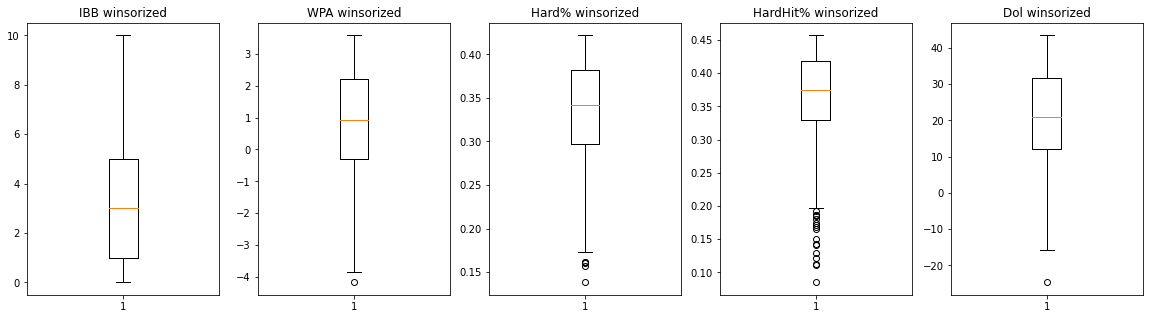

In [14]:
wins_ibb = winsorize(training_df['IBB'], (0, 0.10))
wins_wpa = winsorize(training_df['WPA'], (0, 0.10))
wins_hard = winsorize(training_df['Hard%'], (0, 0.10))
wins_hardhit = winsorize(training_df['HardHit%'], (0, 0.10))
wins_dol = winsorize(training_df['Dol'], (0, 0.10))

plt.figure(figsize=(20, 5))
plt.subplot(1, 5, 1)
plt.boxplot(wins_ibb)
plt.title("IBB winsorized")

plt.subplot(1, 5, 2)
plt.boxplot(wins_wpa)
plt.title("WPA winsorized")

plt.subplot(1, 5, 3)
plt.boxplot(wins_hard)
plt.title("Hard% winsorized")

plt.subplot(1, 5, 4)
plt.boxplot(wins_hardhit)
plt.title("HardHit% winsorized")

plt.subplot(1, 5, 5)
plt.boxplot(wins_dol)
plt.title("Dol winsorized")

plt.show()

In [15]:
training_df['wins_ibb'] = pd.Series(wins_ibb, index=training_df.index)
training_df['wins_wpa'] = pd.Series(wins_ibb, index=training_df.index)
training_df['wins_hard'] = pd.Series(wins_ibb, index=training_df.index)
training_df['wins_hardhit'] = pd.Series(wins_ibb, index=training_df.index)
training_df['wins_dol'] = pd.Series(wins_dol, index=training_df.index)

training_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 989 entries, 2 to 990
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Season        989 non-null    int64  
 1   Name          989 non-null    object 
 2   Team          989 non-null    object 
 3   Age           989 non-null    int64  
 4   PA            989 non-null    int64  
 5   G             989 non-null    int64  
 6   H             989 non-null    int64  
 7   1B            989 non-null    int64  
 8   2B            989 non-null    int64  
 9   3B            989 non-null    int64  
 10  HR            989 non-null    int64  
 11  R             989 non-null    int64  
 12  RBI           989 non-null    int64  
 13  BB            989 non-null    int64  
 14  IBB           989 non-null    int64  
 15  SO            989 non-null    int64  
 16  AVG           989 non-null    float64
 17  WAR           989 non-null    float64
 18  wRC+          989 non-null    

Now, let's look at the test set.

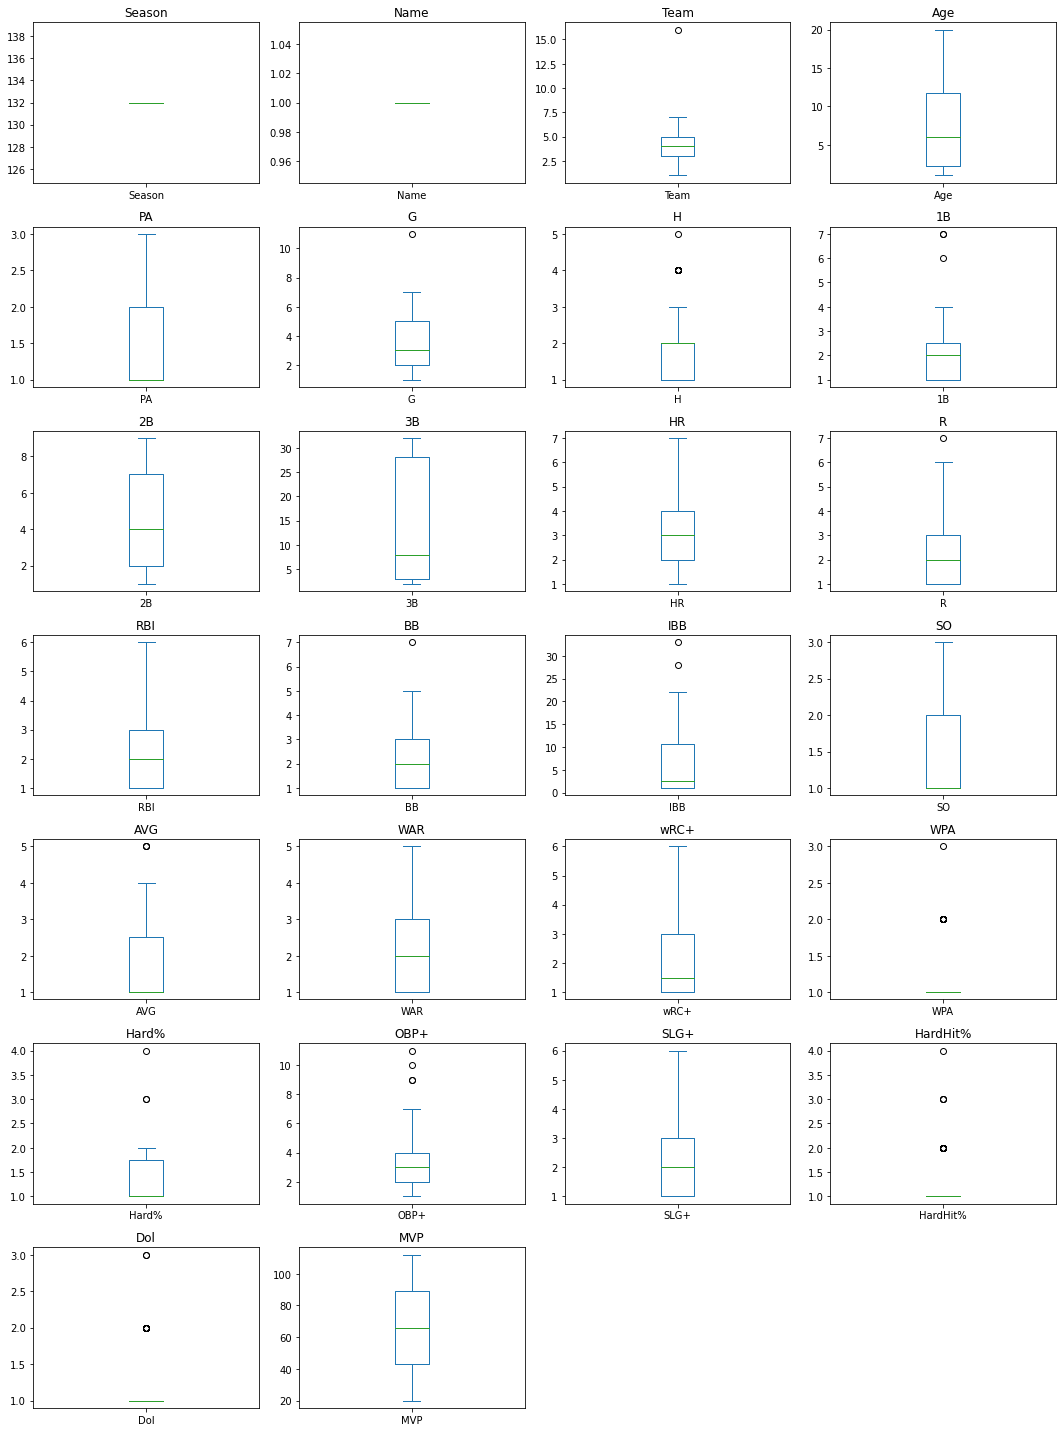

In [16]:
fig = plt.figure(figsize = (15, 20))

for i, col in enumerate(test_df, 1):
    fig.add_subplot(7, 4, i,)
    test_df[col].value_counts().plot(kind='box', ax=plt.gca())
    plt.title(col)
plt.tight_layout()
plt.show()

This dataset has a lot more outliers, but the dataset is much smaller. Since we have the training set outliers treated, we will make the features match the test set, and move on to data exploration.

In [17]:
wins_ibb = winsorize(test_df['IBB'], (0, 0.10))
wins_wpa = winsorize(test_df['WPA'], (0, 0.10))
wins_hard = winsorize(test_df['Hard%'], (0, 0.10))
wins_hardhit = winsorize(test_df['HardHit%'], (0, 0.10))
wins_dol = winsorize(test_df['Dol'], (0, 0.10))

test_df['wins_ibb'] = pd.Series(wins_ibb, index=test_df.index)
test_df['wins_wpa'] = pd.Series(wins_ibb, index=test_df.index)
test_df['wins_hard'] = pd.Series(wins_ibb, index=test_df.index)
test_df['wins_hardhit'] = pd.Series(wins_ibb, index=test_df.index)
test_df['wins_dol'] = pd.Series(wins_dol, index=test_df.index)
test_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Season        132 non-null    int64  
 1   Name          132 non-null    object 
 2   Team          132 non-null    object 
 3   Age           132 non-null    int64  
 4   PA            132 non-null    int64  
 5   G             132 non-null    int64  
 6   H             132 non-null    int64  
 7   1B            132 non-null    int64  
 8   2B            132 non-null    int64  
 9   3B            132 non-null    int64  
 10  HR            132 non-null    int64  
 11  R             132 non-null    int64  
 12  RBI           132 non-null    int64  
 13  BB            132 non-null    int64  
 14  IBB           132 non-null    int64  
 15  SO            132 non-null    int64  
 16  AVG           132 non-null    float64
 17  WAR           132 non-null    float64
 18  wRC+          132 non-null    

## Feature engineering

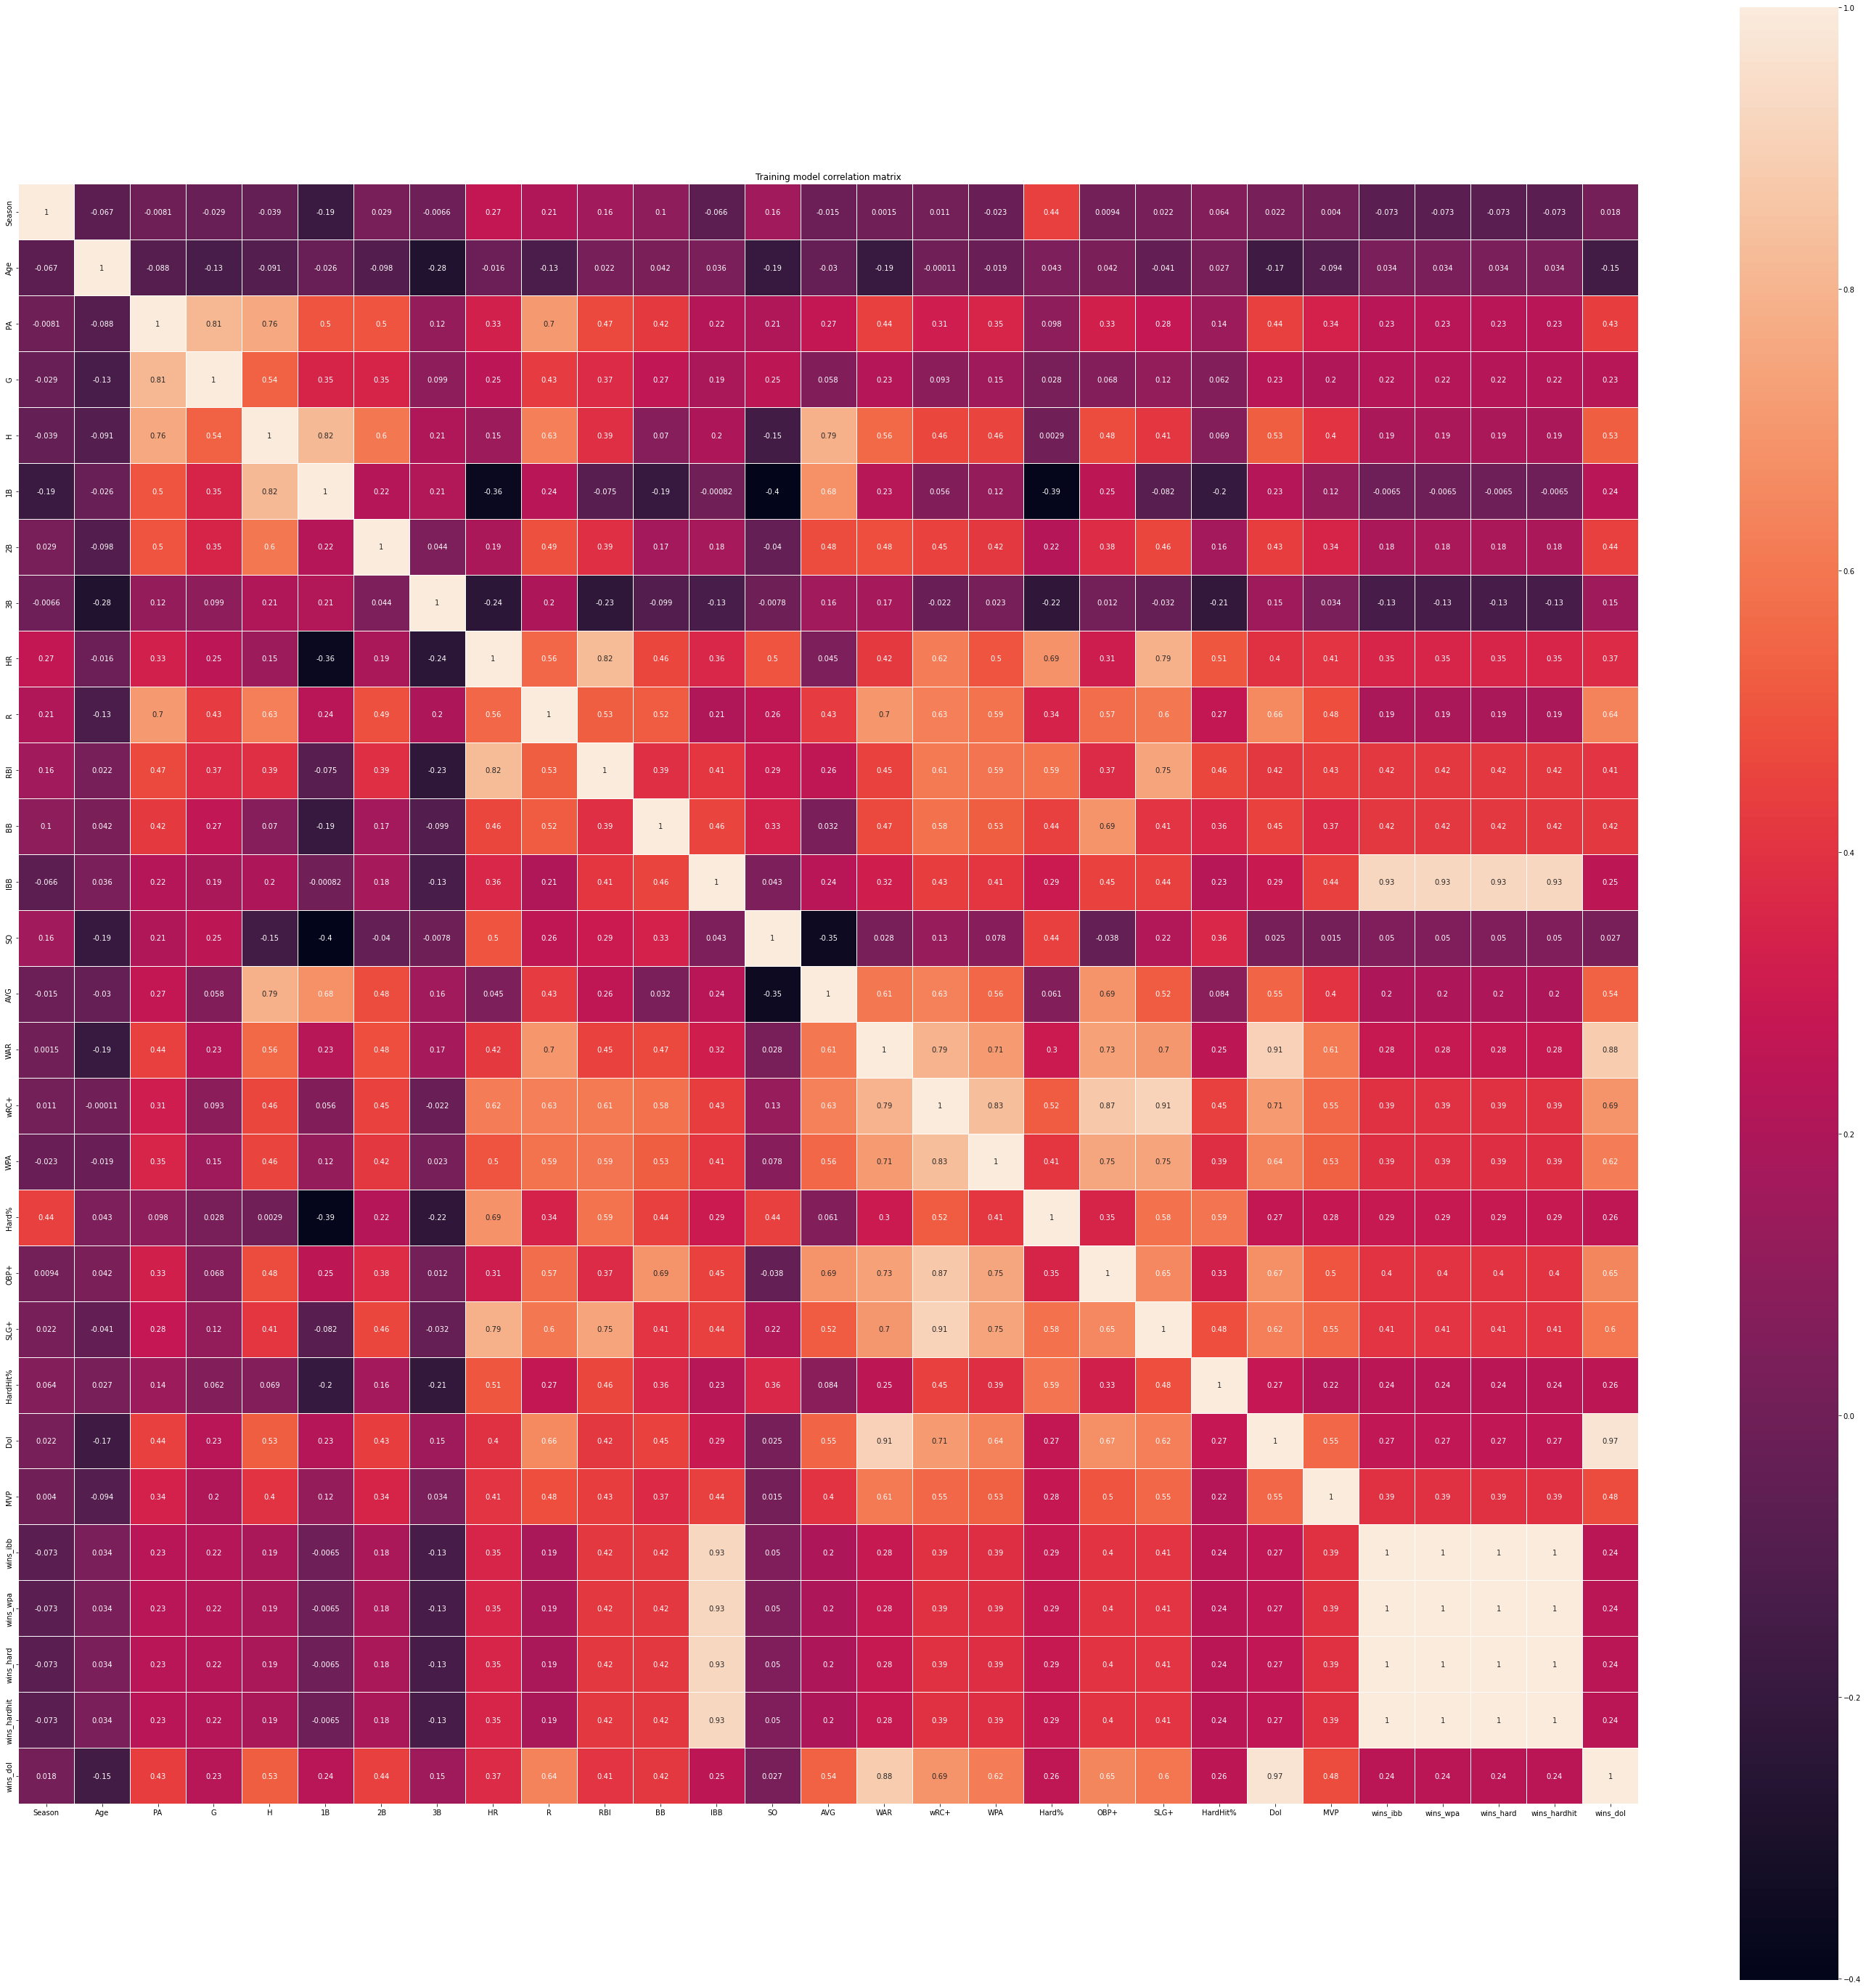

                Season       Age        PA         G         H        1B  \
Season        1.000000 -0.067265 -0.008060 -0.028995 -0.039205 -0.185122   
Age          -0.067265  1.000000 -0.088413 -0.132060 -0.091224 -0.026245   
PA           -0.008060 -0.088413  1.000000  0.810714  0.756403  0.500459   
G            -0.028995 -0.132060  0.810714  1.000000  0.535574  0.347960   
H            -0.039205 -0.091224  0.756403  0.535574  1.000000  0.818778   
1B           -0.185122 -0.026245  0.500459  0.347960  0.818778  1.000000   
2B            0.029229 -0.098364  0.501575  0.345050  0.602217  0.220182   
3B           -0.006594 -0.277645  0.121192  0.098651  0.205282  0.213186   
HR            0.267982 -0.015881  0.327487  0.249295  0.145274 -0.364103   
R             0.209544 -0.126513  0.704718  0.427817  0.626214  0.237483   
RBI           0.158793  0.022481  0.465239  0.374317  0.388274 -0.075069   
BB            0.099513  0.041528  0.421090  0.265411  0.070166 -0.194711   
IBB         

In [18]:
training_corr = training_df.corr()
test_corr = test_df.corr()


plt.figure(figsize=(50, 50))

sns.heatmap(training_corr, square=True, annot=True, linewidths=.5)
plt.title("Training model correlation matrix")
plt.show()

print(training_corr)


Based on the training model correlation, we will use features that has a correlation coefficient of at least |0.4| with MVP. 

In [19]:
X_train = training_df[['HR', 'R', 'RBI', 'IBB', 'AVG', 'WAR', 'wRC+', 'WPA', 'OBP+', 'SLG+', 'Dol', 'wins_dol']]
y_train = training_df['MVP']
X_test = test_df[['HR', 'R', 'RBI', 'IBB', 'AVG', 'WAR', 'wRC+', 'WPA', 'OBP+', 'SLG+', 'Dol', 'wins_dol']]
y_test = test_df['MVP']

## Model building

In [20]:
# Logistic regression
lr = LogisticRegression(solver='lbfgs', max_iter = 1000)
lr.fit(X_train, y_train)
lr_score = lr.score(X_test, y_test)
lr_prediction = lr.predict(X_test)

# KNN (K = 7)
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train, y_train)
knn_score = knn.score(X_test, y_test)
knn_prediction = knn.predict(X_test)

# Decision tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_score = dt.score(X_test, y_test)
dt_prediction = dt.predict (X_test)

# Random forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_score = rf.score(X_test, y_test)
rf_prediction = rf.predict (X_test)

# SVM
svm = LinearSVC(max_iter = 10000)
svm.fit(X_train, y_train)
svm_score = svm.score(X_test, y_test)
svm_prediction = svm.predict(X_test)

# Gradient boost
params = {'n_estimators': 500,
         'max_depth': 2,
         'loss': 'deviance'}
gb = ensemble.GradientBoostingClassifier(**params)
gb.fit(X_train, y_train)
gb_score = gb.score(X_test, y_test)
gb_prediction = gb.predict(X_test)

## Model evaluation

In [21]:
def plot_confusion_matrix(cm, classes, normalize, title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
  """
  This function prints and plots the confusion matrix. 
  Normalization can be applied by setting 'normalize = True'.
  """
  if normalize:
    cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")

  plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment = 'center', verticalalignment = 'center',
             color = 'white' if  cm[i, j] > thresh else 'black')
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization


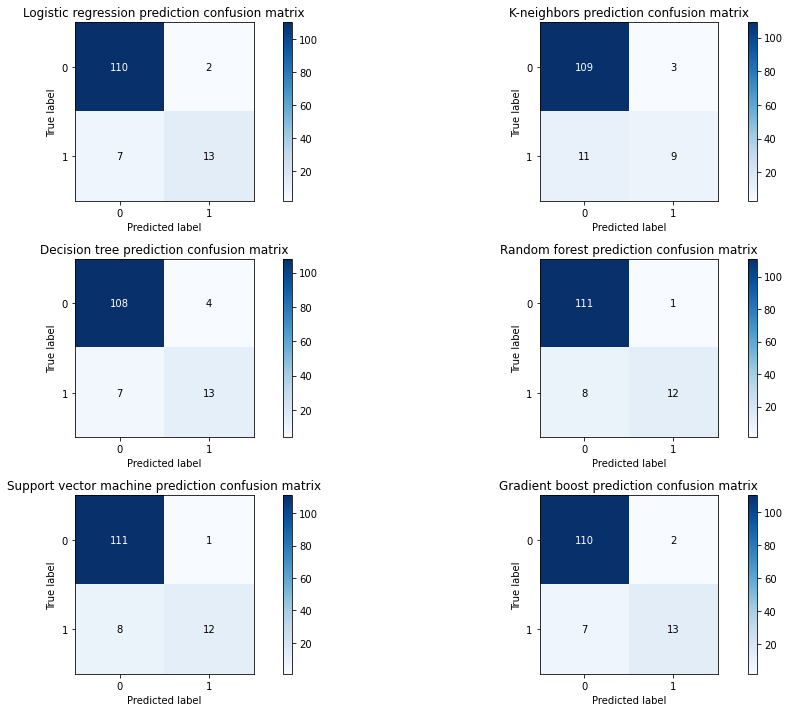

In [22]:
cm_lr = confusion_matrix(y_test, lr_prediction)
cm_knn = confusion_matrix(y_test, knn_prediction)
cm_dt = confusion_matrix(y_test, dt_prediction)
cm_rf = confusion_matrix(y_test, rf_prediction)
cm_svm = confusion_matrix(y_test, svm_prediction)
cm_gb = confusion_matrix(y_test, gb_prediction)

plt.figure(figsize = (15, 10))
plt.subplot(3, 2, 1)
plot_confusion_matrix(cm_lr, [0, 1], False)
plt.title("Logistic regression prediction confusion matrix")
plt.subplot(3, 2, 2)
plot_confusion_matrix(cm_knn, [0, 1], False)
plt.title("K-neighbors prediction confusion matrix")
plt.subplot(3, 2, 3)
plot_confusion_matrix(cm_dt, [0, 1], False)
plt.title("Decision tree prediction confusion matrix")
plt.subplot(3, 2, 4)
plot_confusion_matrix(cm_rf, [0, 1], False)
plt.title("Random forest prediction confusion matrix")
plt.subplot(3, 2, 5)
plot_confusion_matrix(cm_svm, [0, 1], False)
plt.title("Support vector machine prediction confusion matrix")
plt.subplot(3, 2, 6)
plot_confusion_matrix(cm_gb, [0, 1], False)
plt.title("Gradient boost prediction confusion matrix")

plt.tight_layout()
plt.show()

In [23]:
print("-----Logistic Regression-----")
print("Training set R-squared: {}".format(lr.score(X_train, y_train)))
print("Accuracy (Test sest R-squared): {:.3f} | Precision: {:.3f} | Recall: {:.3f}".format(lr.score(X_test, y_test), 
                                                                    precision_score(y_test, lr_prediction), 
                                                                    recall_score(y_test, lr_prediction)))
print("MAE: {:.3f} | MSE: {:.3f} | RMSE: {:.3f} | MAPE: {:.3f}".format(mean_absolute_error(y_test, lr_prediction),
                                                                      mse(y_test, lr_prediction),
                                                                      rmse(y_test, lr_prediction),
                                                                      np.mean(np.abs((y_test - lr_prediction)/y_test))*100))
print("Mean Cross validation: {}".format(np.mean(cross_val_score(lr, X_train, y_train, cv=5))))
print("\n-----KNN-----")
print("Training set R-squared: {}".format(knn.score(X_train, y_train)))
print("Accuracy (Test sest R-squared): {:.3f} | Precision: {:.3f} | Recall: {:.3f}".format(knn.score(X_test, y_test), 
                                                                    precision_score(y_test, knn_prediction), 
                                                                    recall_score(y_test, knn_prediction)))
print("MAE: {:.3f} | MSE: {:.3f} | RMSE: {:.3f} | MAPE: {:.3f}".format(mean_absolute_error(y_test, knn_prediction),
                                                                      mse(y_test, knn_prediction),
                                                                      rmse(y_test, knn_prediction),
                                                                      np.mean(np.abs((y_test - knn_prediction)/y_test))*100))
print("Mean Cross validation: {}".format(np.mean(cross_val_score(knn, X_train, y_train, cv=5))))
print("\n-----Decision Tree-----")
print("Training set R-squared: {}".format(dt.score(X_train, y_train)))
print("Accuracy (Test sest R-squared): {:.3f} | Precision: {:.3f} | Recall: {:.3f}".format(dt.score(X_test, y_test), 
                                                                    precision_score(y_test, dt_prediction), 
                                                                    recall_score(y_test, dt_prediction)))
print("MAE: {:.3f} | MSE: {:.3f} | RMSE: {:.3f} | MAPE: {:.3f}".format(mean_absolute_error(y_test, dt_prediction),
                                                                      mse(y_test, dt_prediction),
                                                                      rmse(y_test, dt_prediction),
                                                                      np.mean(np.abs((y_test - dt_prediction)/y_test))*100))
print("Mean Cross validation: {}".format(np.mean(cross_val_score(dt, X_train, y_train, cv=5))))
print("\n-----Random Forest-----")
print("Training set R-squared: {}".format(rf.score(X_train, y_train)))
print("Accuracy (Test sest R-squared): {:.3f} | Precision: {:.3f} | Recall: {:.3f}".format(rf.score(X_test, y_test), 
                                                                    precision_score(y_test, rf_prediction), 
                                                                    recall_score(y_test, rf_prediction)))
print("MAE: {:.3f} | MSE: {:.3f} | RMSE: {:.3f} | MAPE: {:.3f}".format(mean_absolute_error(y_test, rf_prediction),
                                                                      mse(y_test, rf_prediction),
                                                                      rmse(y_test, rf_prediction),
                                                                      np.mean(np.abs((y_test - rf_prediction)/y_test))*100))
print("Mean Cross validation: {}".format(np.mean(cross_val_score(rf, X_train, y_train, cv=5))))
print("\n-----SVM-----")
print("Training set R-squared: {}".format(svm.score(X_train, y_train)))
print("Accuracy (Test sest R-squared): {:.3f} | Precision: {:.3f} | Recall: {:.3f}".format(svm.score(X_test, y_test), 
                                                                    precision_score(y_test, svm_prediction), 
                                                                    recall_score(y_test, svm_prediction)))
print("MAE: {:.3f} | MSE: {:.3f} | RMSE: {:.3f} | MAPE: {:.3f}".format(mean_absolute_error(y_test, svm_prediction),
                                                                      mse(y_test, svm_prediction),
                                                                      rmse(y_test, svm_prediction),
                                                                      np.mean(np.abs((y_test - svm_prediction)/y_test))*100))
print("Mean Cross validation: {}".format(np.mean(cross_val_score(svm, X_train, y_train, cv=5))))
print("\n-----Gradient Boost-----")
print("Training set R-squared: {}".format(gb.score(X_train, y_train)))
print("Accuracy (Test sest R-squared): {:.3f} | Precision: {:.3f} | Recall: {:.3f}".format(gb.score(X_test, y_test), 
                                                                    precision_score(y_test, gb_prediction), 
                                                                    recall_score(y_test, gb_prediction)))
print("MAE: {:.3f} | MSE: {:.3f} | RMSE: {:.3f} | MAPE: {:.3f}".format(mean_absolute_error(y_test, gb_prediction),
                                                                      mse(y_test, gb_prediction),
                                                                      rmse(y_test, gb_prediction),
                                                                      np.mean(np.abs((y_test - gb_prediction)/y_test))*100))
print("Mean Cross validation: {}".format(np.mean(cross_val_score(gb, X_train, y_train, cv=5))))


-----Logistic Regression-----
Training set R-squared: 0.9635995955510617
Accuracy (Test sest R-squared): 0.932 | Precision: 0.867 | Recall: 0.650
MAE: 0.068 | MSE: 0.068 | RMSE: 0.261 | MAPE: 35.000
Mean Cross validation: 0.9443367687022508

-----KNN-----
Training set R-squared: 0.9544994944388271
Accuracy (Test sest R-squared): 0.894 | Precision: 0.750 | Recall: 0.450
MAE: 0.106 | MSE: 0.106 | RMSE: 0.326 | MAPE: 55.000
Mean Cross validation: 0.9301902271445417

-----Decision Tree-----
Training set R-squared: 1.0
Accuracy (Test sest R-squared): 0.917 | Precision: 0.765 | Recall: 0.650
MAE: 0.083 | MSE: 0.083 | RMSE: 0.289 | MAPE: 35.000
Mean Cross validation: 0.9271189047838794

-----Random Forest-----
Training set R-squared: 1.0
Accuracy (Test sest R-squared): 0.932 | Precision: 0.923 | Recall: 0.600
MAE: 0.068 | MSE: 0.068 | RMSE: 0.261 | MAPE: 40.000
Mean Cross validation: 0.9433369225247399

-----SVM-----
Training set R-squared: 0.9585439838220424
Accuracy (Test sest R-squared): 0

First off, the worst performing model is support vector machine. Despite, all 6 models seems to be doing really well - almost too well. I will use some overfit methods.

In [24]:
# Logistic regression with regularization
lr_l2 = LogisticRegression(solver='lbfgs', penalty = 'l2', max_iter = 10000)
lr_l2.fit(X_train, y_train)
lr_l2_score = lr_l2.score(X_test, y_test)
lr_l2_prediction = lr_l2.predict(X_test)

# Ridge classifier with built-in cross-validation
ridgeCV = RidgeClassifierCV()
ridgeCV.fit(X_train, y_train)
ridgeCV_score = ridgeCV.score(X_test, y_test)
ridgeCV_prediction = ridgeCV.predict(X_test)

print("-----Logistic regression with regularization-----")
print("Training set R-squared: {}".format(lr_l2.score(X_train, y_train)))
print("Accuracy (Test sest R-squared): {:.3f} | Precision: {:.3f} | Recall: {:.3f}".format(lr_l2.score(X_test, y_test), 
                                                                    precision_score(y_test, lr_l2_prediction), 
                                                                    recall_score(y_test, lr_l2_prediction)))
print("MAE: {:.3f} | MSE: {:.3f} | RMSE: {:.3f} | MAPE: {:.3f}".format(mean_absolute_error(y_test, lr_l2_prediction),
                                                                      mse(y_test, lr_l2_prediction),
                                                                      rmse(y_test, lr_l2_prediction),
                                                                      np.mean(np.abs((y_test - lr_l2_prediction)/y_test))*100))
print("Mean Cross validation: {}".format(np.mean(cross_val_score(lr_l2, X_train, y_train, cv=5))))

print("\n-----Ridge classifier with built-in cross-validation-----")
print("Training set R-squared: {}".format(ridgeCV.score(X_train, y_train)))
print("Accuracy (Test sest R-squared): {:.3f} | Precision: {:.3f} | Recall: {:.3f}".format(ridgeCV.score(X_test, y_test), 
                                                                    precision_score(y_test, ridgeCV_prediction), 
                                                                    recall_score(y_test, ridgeCV_prediction)))
print("MAE: {:.3f} | MSE: {:.3f} | RMSE: {:.3f} | MAPE: {:.3f}".format(mean_absolute_error(y_test, ridgeCV_prediction),
                                                                      mse(y_test, ridgeCV_prediction),
                                                                      rmse(y_test, ridgeCV_prediction),
                                                                      np.mean(np.abs((y_test - ridgeCV_prediction)/y_test))*100))
print("Mean Cross validation: {}".format(np.mean(cross_val_score(ridgeCV, X_train, y_train, cv=5))))

-----Logistic regression with regularization-----
Training set R-squared: 0.9635995955510617
Accuracy (Test sest R-squared): 0.932 | Precision: 0.867 | Recall: 0.650
MAE: 0.068 | MSE: 0.068 | RMSE: 0.261 | MAPE: 35.000
Mean Cross validation: 0.9443367687022508

-----Ridge classifier with built-in cross-validation-----
Training set R-squared: 0.9342770475227502
Accuracy (Test sest R-squared): 0.909 | Precision: 1.000 | Recall: 0.400
MAE: 0.091 | MSE: 0.091 | RMSE: 0.302 | MAPE: 60.000
Mean Cross validation: 0.9332615495052042


Both models have pretty good outcome, even with considering the regularization is applied. The R-squared numbers are close to 96%,and the error evalution metrics are very small. The model represents the dataset well, and predicts the target very well.

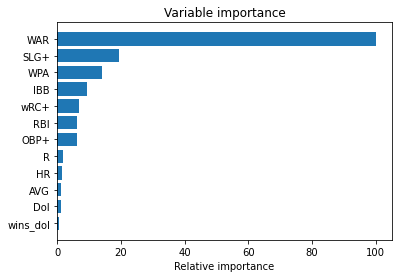

In [25]:
feature_importance = gb.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel("Relative importance")
plt.title("Variable importance")
plt.show()

The histogram above indicates that **Wins Above Replacement** is by far the most important feature in the Gradient Boost model. 

## Conclusion
With 12 features that we have selected, all models performed well in predicting who will be the top 10 MVP nominee in each league. Even with the regularization, the accuracy, precision, and recall did not drastically drop. Looking at the feature importance, WAR is by far the most important feature in predicting the MVP nominee. For the next model, I will go back to feature engineering and only use SLG+, WPA, IBB, wRC+, RBI, and OBP+ to see if I will get the same high-performing models.